In [1]:
from ringdb import Database
import ringdown
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
from exact_coeffs import interpolation_coeffs
import matplotlib.pyplot as plt

In [2]:
db = Database('./Data')
db.initialize()

In [3]:
db.update_posterior_schema({'f_low': {'path': "/{approximant}/meta_data/meta_data/f_low", 'type':'value'}})
db.update_posterior_schema({'f_ref': {'path': "/{approximant}/meta_data/meta_data/f_ref", 'type':'value'}})

In [248]:
eventname = 'GW150914'


def get_target(eventname, N_samps=None, target_sample_rate=4096, f_low=20, f_ref=20, q=0.5):
    event = db.event(eventname)
    strains = event.strain()
    posts = event.posteriors()

    N_samps = N_samps or len(posts)

    try:
        f_low = float(event.read_posterior_file_from_schema('f_low'))
        f_ref = float(event.read_posterior_file_from_schema('f_ref'))
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
    except:
        print("Falling back to f_ref = 20, f_low=20")
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
        f_low = f_low
        f_ref = f_ref


    print(f"Using {waveform_name}")
    wf_ls = waveform_code
    sample_rate = np.max([a.fsamp for a in strains.values()])


    samps = [x.to_dict() for i,x in posts.sample(N_samps).iterrows()]

    for i,x in enumerate(samps):
        t_peak, t_dict, hp, hc = ringdown.complex_strain_peak_time_td(x,
                                                                      wf=wf_ls, dt=1/target_sample_rate,
                                                                      f_ref=f_ref, f_low=f_low)
        samps[i].update({k+'_peak':v for k,v in t_dict.items()})

    samps = pd.DataFrame(samps)

    # Get median sample
    ref_ifo = 'H1'
    im = (samps[f'{ref_ifo}_peak'] - samps[f'{ref_ifo}_peak'].quantile(q)).abs().argmin()
    median_samp = samps.iloc[im]

    # Construct Arguments for set_target
    args = median_samp[['geocent_peak', 'ra','dec','psi']].rename({'geocent_peak':'t0'}).to_dict()
    print("The median time at H1 is: ", median_samp['H1_peak'], "s")

    # Get the mass time-scale
    Mass_Time = lambda M: 6.674e-11*M*1.989e+30/(3e8)**3
    t_M = Mass_Time(median_samp['final_mass'])
    print("The mass time-scale is: ", np.round(t_M*1000,3), "ms")

    times_above_below = (samps['H1_peak'].quantile(0.95) - samps['H1_peak'].quantile(0.05))/(2*t_M)
    print(f"The 90% CI of H1 peak time is +/- {np.round(times_above_below,1)} t_M")

    return args, median_samp, samps


def set_fit(eventname, target, mass_for_prior, duration=0.1, target_sample_rate=4096, model='mchi', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)], **model_kwargs):
    event = db.event(eventname)
    strains = event.strain()
    
    fit = ringdown.Fit(model=model, modes=modes, **model_kwargs)
    
    for ifo in strains.keys():
        fit.add_data(strains[ifo])
        
    sample_rate = np.max([f.fsamp for f in strains.values()])

    fit.set_target(**target, duration=duration)
    fit.condition_data(ds=int(sample_rate/target_sample_rate),digital_filter=True)
    fit.compute_acfs()

    fit.update_prior(A_scale=5e-21, M_min=mass_for_prior*0.5,
                     M_max=mass_for_prior*2.0,
                     flat_A=1)
    return fit

def combined_results(fit_result, imrs):
    cols = [(r'$M$','M'), (r'$\chi$','chi')]
    the_result = pd.DataFrame({col[0]: fit_result['posterior'][col[1]].values.flatten() for col in cols})
    the_result['result'] = 'Ringdown'

    cols = [(r'$M$','final_mass'), (r'$\chi$','final_spin')]
    the_result2 = pd.DataFrame({col[0]: posts[col[1]].values.flatten() for col in cols})
    the_result2['result'] = 'IMR'

    the_result = pd.concat([the_result, the_result2]).reset_index(drop=True)
    return the_result

In [188]:
args, median_samp, samps = get_target('GW150914', N_samps=800, q=0.1)

#args = dict(t0=1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82)
#args2 = samps.iloc[samps['log_likelihood'].argmax()][['geocent_peak', 'ra','dec','psi']].rename({'geocent_peak':'t0'}).to_dict()

#fit = set_fit('GW150914', args, median_samp['final_mass'])
#fit_charged = set_fit('GW150914', args, median_samp['final_mass'], model='mchiq_exact', **interpolation_coeffs)
#fit_charged_MAP = set_fit('GW150914', args2, median_samp['final_mass'], model='mchiq_exact', **interpolation_coeffs)
fit_charged_10perc = set_fit('GW150914', args, median_samp['final_mass'], model='mchiq_exact', **interpolation_coeffs)

Falling back to f_ref = 20, f_low=20
Using IMRPhenomPv2
The median time at H1 is:  1126259462.4228072 s
The mass time-scale is:  0.337 ms
The 90% CI of H1 peak time is +/- 3.0 t_M


In [186]:
samps.iloc[samps['log_likelihood'].nlargest(800).index].H1_peak.median()

1126259462.423562

In [178]:
samps[]

,chirp_mass,mass_ratio,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,theta_jn,psi,...,waveform_code,final_spin,peak_luminosity,final_mass,final_mass_source,radiated_energy,geocent_peak,H1_peak,L1_peak,V1_peak
0,29.975306,0.683158,0.574153,0.409844,1.860066,1.614258,3.698436,0.458453,2.922535,0.276089,...,79,0.640164,3.229361,67.383280,61.065619,2.708636,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09
1,31.961771,0.787005,0.076214,0.048479,1.883097,0.599397,1.724850,1.784111,2.609259,1.557259,...,79,0.678494,3.587172,70.573197,64.045146,3.166061,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09
2,30.888371,0.788130,0.306958,0.827461,0.984391,1.992231,3.866485,2.414221,3.029962,0.211045,...,79,0.681177,3.564022,68.246547,61.312403,2.983434,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09
3,32.309736,0.999567,0.084111,0.398875,0.599659,1.394373,3.791421,5.395984,2.319129,2.517242,...,79,0.712810,3.831366,70.495189,64.396489,3.410136,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09
4,30.328411,0.794827,0.004496,0.340163,1.909677,2.302826,2.888340,1.731484,2.643261,2.545244,...,79,0.654227,3.463751,67.072322,62.120830,2.923154,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,31.659903,0.814794,0.415101,0.111958,1.773636,0.457471,2.596273,1.298779,2.906621,0.906835,...,79,0.685247,3.600542,69.738936,64.058533,3.173363,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09
796,31.458382,0.915344,0.754111,0.644496,1.395449,1.732151,2.660861,4.891095,2.860758,1.265947,...,79,0.699066,3.738054,68.823005,61.914615,3.179462,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09
797,32.223901,0.575200,0.785063,0.851992,0.941392,2.543779,2.351530,6.063758,2.859128,1.879414,...,79,0.752824,3.459022,73.873946,67.150533,3.261649,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09
798,30.736513,0.904378,0.435569,0.472772,2.211166,1.016670,0.917068,4.697065,2.529446,2.684583,...,79,0.693366,3.638258,67.364025,61.603085,3.069886,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09


In [22]:
#fit_charged_not_flat = set_fit('GW150914', args, median_samp['final_mass'], model='mchiq_exact', **interpolation_coeffs)

In [31]:
fit.run(draws=2000, target_accept=0.95, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
INFO:pymc:NUTS: [M, chi, Apx_unit, Apy_unit, Acx_unit, Acy_unit, df, dtau]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 771 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 771 seconds.
The acceptance probability does not match the target. It is 0.9926, but should be close to 0.95. Try to increase the number of tuning steps.


In [189]:
fit_charged_10perc.run()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
INFO:pymc:Initializing NUTS using jitter+adapt_full...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, r2_qchi, theta_qchi, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
INFO:pymc:NUTS: [M, r2_qchi, theta_qchi, Apx_unit, Apy_unit, Acx_unit, Acy_unit]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 417 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 417 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [259]:
def Make_Plots(result, posts, eventname, chain=[0,1,2,3]):
    result = result.sel(chain=chain)
    M_chi = combined_results(result, posts)
    result = result['posterior']
    g = sns.jointplot(data=M_chi, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, levels=[0.3,0.6,0.9], common_norm=False, alpha=0.7)

    g.fig.suptitle(f"{eventname} M vs "+r"$\chi$")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    plt.show()
    
    chi_Q = pd.DataFrame({r'$Q$': result['Q_charge'].values.flatten(),
              r'$\chi$': result['chi'].values.flatten()})

    g = sns.jointplot(data=chi_Q, y=r'$\chi$', x=r'$Q$', 
                  kind='hex')
    x = np.linspace(0,1,100)
    g.ax_joint.plot(x, np.sqrt(1-x**2))
    g.ax_joint.set_xlim((0,1))
    g.ax_joint.set_ylim((0,1))
    g.fig.suptitle(f"{eventname} Q vs"+r"$\chi$" + " hexbin")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    plt.show()
    
    
    g = sns.jointplot(data=chi_Q, y=r'$\chi$', x=r'$Q$', 
              kind='kde', levels=[0.3,0.6,0.9], fill=True, alpha=0.7)
    x = np.linspace(0,1,100)
    g.ax_joint.plot(x, np.sqrt(1-x**2))
    g.ax_joint.set_xlim((0,1))
    g.ax_joint.set_ylim((0,1))
    g.ax_joint.plot(plotdf[r'$Q$'].median(),plotdf[r'$\chi$'].median(),'+',c='k')
    g.fig.suptitle(f"{eventname} charged run")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    
    
    pts = np.array([chi_Q[r'$Q$'], chi_Q[r'$\chi$']])
    fig, ax = plt.subplots(1,figsize=(6,6))
    Bounded_KDE_Plot_Quadrant(pts, ax=ax, title="Bounded KDE constraints\n for GW150914")
    plt.show()

    
def kdeplot_2d_clevels_return(xs, ys, levels=11, **kwargs):
    try:
        xs = xs.values.astype(float)
        ys = ys.values.astype(float)
    except AttributeError:
        pass
    
    try:
        len(levels)
        f = 1 - np.array(levels)
    except TypeError:
        f = linspace(0, 1, levels+2)[1:-1]
    if kwargs.get('auto_bound', False):
        kwargs['xlow'] = min(xs)
        kwargs['xhigh'] = max(xs)
        kwargs['ylow'] = min(ys)
        kwargs['yhigh'] = max(ys)
    kde_kws = {k: kwargs.pop(k, None) for k in ['xlow', 'xhigh', 'ylow', 'yhigh']}
    k = ringdown.Bounded_2d_kde(np.column_stack((xs, ys)), **kde_kws)
    size = max(10*(len(f)+2), 500)
    c = np.random.choice(len(xs), size=size)
    p = k(np.column_stack((xs[c], ys[c])))
    i = np.argsort(p)
    l = np.array([p[i[int(round(ff*len(i)))]] for ff in f])

    x = np.linspace(0, 1, 128)
    y = np.linspace(0, np.pi/2, 128)

    XS, YS = np.meshgrid(x, y, indexing='ij')
    ZS = k(np.column_stack((XS.flatten(), YS.flatten()))).reshape(XS.shape)
    
    return XS, YS, ZS, l

def Bounded_KDE_Plot_Quadrant(pts, levels=[0.3,0.6,0.9],ax=None, title=None):
    rtheta = np.array([np.array([np.sqrt(a[0]**2 + a[1]**2), np.arctan(a[1]/a[0])]) for a in pts.transpose()])
    kde = ringdown.Bounded_2d_kde(rtheta, xlow=0.0, xhigh=1.0, ylow=0.0, yhigh=np.pi/2)

    RS, ThetaS, ZS, l = kdeplot_2d_clevels_return(rtheta[:,0], rtheta[:,1], levels=levels)


    XS = np.array([[RS[i,j]*np.cos(ThetaS[i,j]) for i in range(RS.shape[0])] for j in range(RS.shape[1])])
    YS = np.array([[RS[i,j]*np.sin(ThetaS[i,j]) for i in range(RS.shape[0])] for j in range(RS.shape[1])])
    ZS = np.array([[ZS[i,j] for i in range(RS.shape[0])] for j in range(RS.shape[1])])

    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5,5))
    ax.contourf(XS, YS, ZS, levels=[l[-i-1] for i in range(len(l))], alpha=0.5)
    t = np.linspace(0,1,100)
    ax.plot(t, np.sqrt(1-t**2))
    ax.set_aspect(1)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.set_xlabel(r"$Q$")
    ax.set_ylabel(r"$\chi$")
    ax.plot(plotdf[r'$Q$'].median(),plotdf[r'$\chi$'].median(),'+',c='k')
    ax.set_title(title or "Attempt at Bounded KDE for charged result")
    return ax

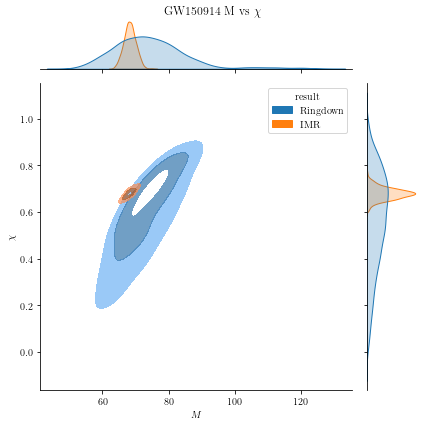

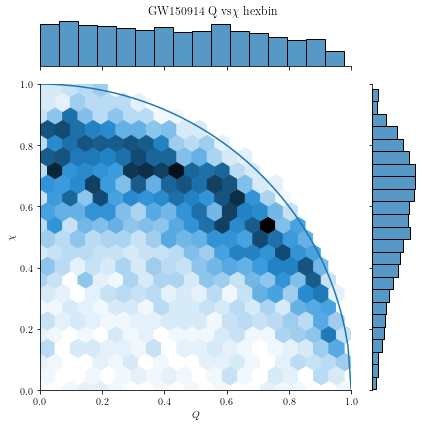

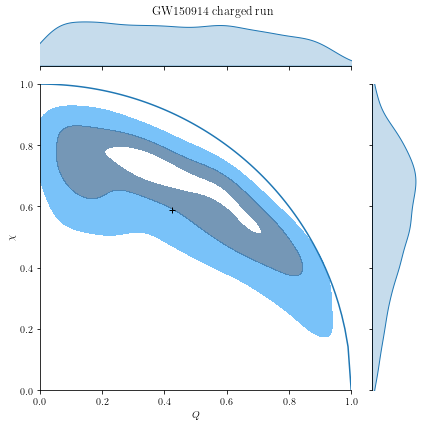

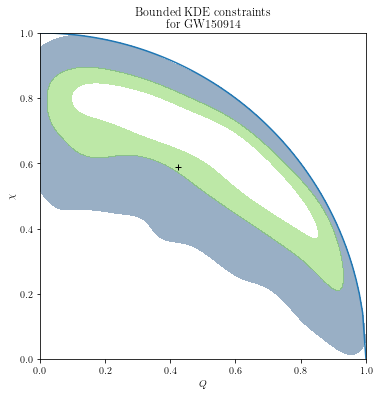

In [258]:
Make_Plots(fit_charged.result, posts, eventname, chain=[0,1,3])

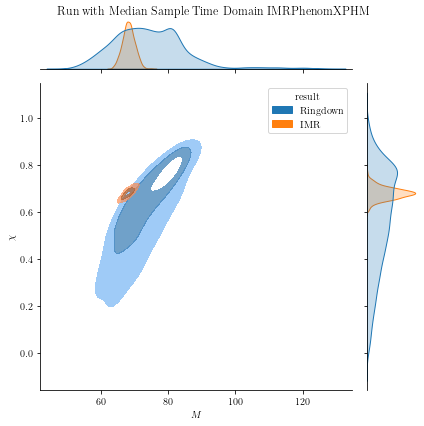

In [251]:
the_result = combined_results(fit_charged.result, posts)
g = sns.jointplot(data=the_result, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, levels=[0.3,0.6,0.9], common_norm=False, alpha=0.7)

g.fig.suptitle("Run with Median Sample Time Domain IMRPhenomXPHM")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

#fit.result.to_netcdf(f'{eventname}-Median-td-{waveform_name}.nc')
plt.show()

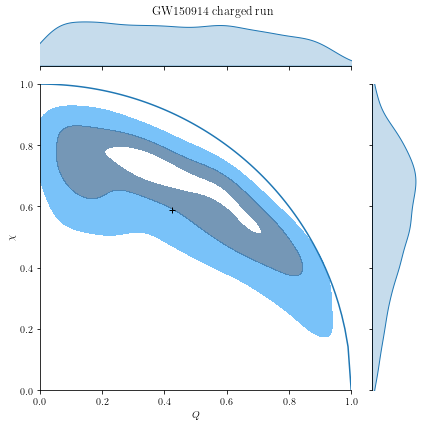

In [217]:
plotdf = pd.DataFrame({r'$Q$': fit_charged.result['posterior'].sel(chain=[0,1,3])['Q_charge'].values.flatten(),
              r'$\chi$': fit_charged.result['posterior'].sel(chain=[0,1,3])['chi'].values.flatten()})


g = sns.jointplot(data=plotdf, y=r'$\chi$', x=r'$Q$', 
              kind='kde', levels=[0.3,0.6,0.9], fill=True, alpha=0.7)
x = np.linspace(0,1,100)
g.ax_joint.plot(x, np.sqrt(1-x**2))
g.ax_joint.set_xlim((0,1))
g.ax_joint.set_ylim((0,1))
g.ax_joint.plot(plotdf[r'$Q$'].median(),plotdf[r'$\chi$'].median(),'+',c='k')
g.fig.suptitle(f"{eventname} charged run")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

#### Attempt at bounded KDE

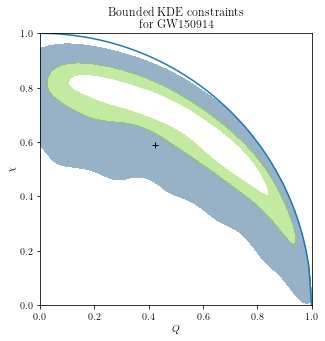

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax = Bounded_KDE_Plot_Quadrant(pts, ax=ax, title="Bounded KDE constraints for GW150914")
plt.savefig("Bounded KDE.pdf", dpi=200)
plt.show()

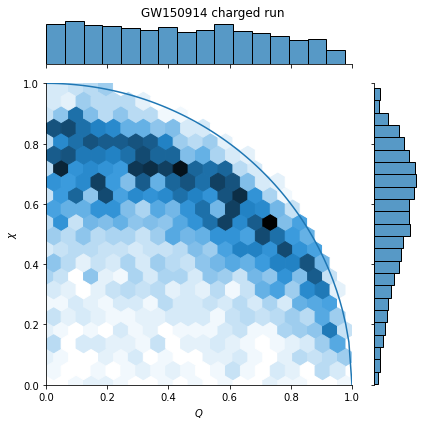

In [121]:
plotdf = pd.DataFrame({r'$Q$': fit_charged.result['posterior'].sel(chain=[0,1,3])['Q_charge'].values.flatten(),
              r'$\chi$': fit_charged.result['posterior'].sel(chain=[0,1,3])['chi'].values.flatten()})

g = sns.jointplot(data=plotdf, y=r'$\chi$', x=r'$Q$', 
              kind='hex')
x = np.linspace(0,1,100)
g.ax_joint.plot(x, np.sqrt(1-x**2))
g.ax_joint.set_xlim((0,1))
g.ax_joint.set_ylim((0,1))
g.fig.suptitle(f"{eventname} charged run")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

In [149]:
np.all(ThetaS <= np.pi/2)

True

In [145]:
samps.iloc[samps['log_likelihood'].argmax()]

chirp_mass                 30.799095
mass_ratio                  0.900803
a_1                         0.613082
a_2                         0.477775
tilt_1                       2.18233
                         ...        
radiated_energy             3.024961
geocent_peak       1126259462.412676
H1_peak            1126259462.423836
L1_peak            1126259462.416966
V1_peak            1126259462.425618
Name: 52, Length: 133, dtype: object

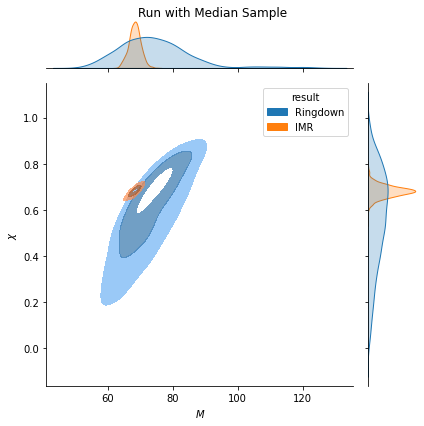

In [22]:
event = db.event('GW150914')
posts = event.posteriors().sample(800)
the_result = combined_results(fit_charged.result.sel(chain=[0,1,3]), posts)
g = sns.jointplot(data=the_result, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, levels=[0.3,0.6,0.9], common_norm=False, alpha=0.7)

g.fig.suptitle("Run with Median Sample")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

#fit.result.to_netcdf(f'{eventname}-Median-td-{waveform_name}.nc')
plt.show()

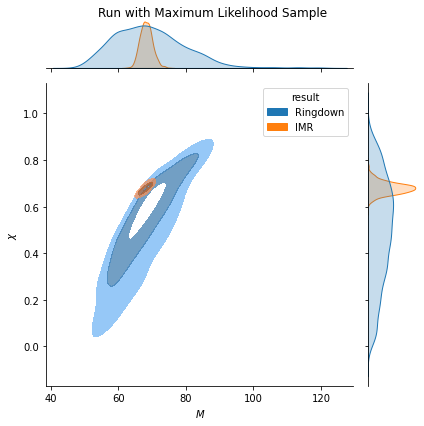

In [155]:
event = db.event('GW150914')
posts = event.posteriors().sample(800)
the_result = combined_results(fit_charged_MAP.result.sel(chain=[0,1,2,3]), posts)
g = sns.jointplot(data=the_result, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, levels=[0.3,0.6,0.9], common_norm=False, alpha=0.7)

g.fig.suptitle("Run with Maximum Likelihood Sample")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

#fit.result.to_netcdf(f'{eventname}-Median-td-{waveform_name}.nc')
plt.show()

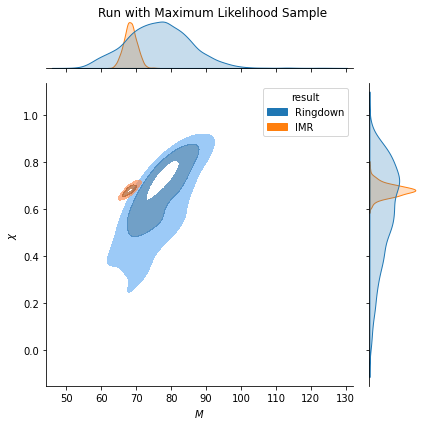

In [192]:
event = db.event('GW150914')
posts = event.posteriors().sample(800)
the_result = combined_results(fit_charged_10perc.result.sel(chain=[0,1,2,3]), posts)
g = sns.jointplot(data=the_result, x=r'$M$', y=r'$\chi$', hue='result', 
              kind='kde', fill=True, levels=[0.3,0.6,0.9], common_norm=False, alpha=0.7)

g.fig.suptitle("Run with Maximum Likelihood Sample")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

#fit.result.to_netcdf(f'{eventname}-Median-td-{waveform_name}.nc')
plt.show()

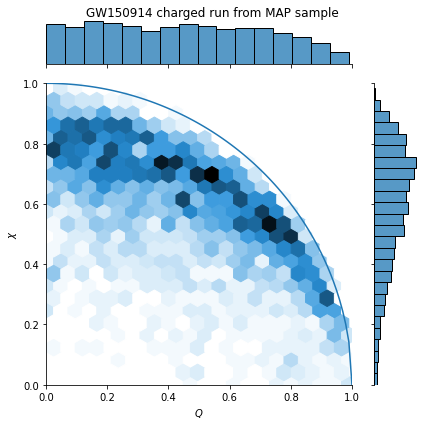

In [191]:
plotdf = pd.DataFrame({r'$Q$': fit_charged_10perc.result['posterior'].sel(chain=[0,2,1])['Q_charge'].values.flatten(),
              r'$\chi$': fit_charged_10perc.result['posterior'].sel(chain=[0,2,1])['chi'].values.flatten()})

g = sns.jointplot(data=plotdf, y=r'$\chi$', x=r'$Q$', 
              kind='hex')
x = np.linspace(0,1,100)
g.ax_joint.plot(x, np.sqrt(1-x**2))
g.ax_joint.set_xlim((0,1))
g.ax_joint.set_ylim((0,1))
g.fig.suptitle(f"{eventname} charged run from MAP sample")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

/Users/asadh/Documents/GitHub/ringdb_test_venv/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (26), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'Apx_unit'}>,
        <AxesSubplot:title={'center':'Apx_unit'}>],
       [<AxesSubplot:title={'center':'Apy_unit'}>,
        <AxesSubplot:title={'center':'Apy_unit'}>],
       [<AxesSubplot:title={'center':'Acx_unit'}>,
        <AxesSubplot:title={'center':'Acx_unit'}>],
       [<AxesSubplot:title={'center':'Acy_unit'}>,
        <AxesSubplot:title={'center':'Acy_unit'}>],
       [<AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'M'}>],
       [<AxesSubplot:title={'center':'r2_qchi'}>,
        <AxesSubplot:title={'center':'r2_qchi'}>],
       [<AxesSubplot:title={'center':'theta_qchi'}>,
        <AxesSubplot:title={'center':'theta_qchi'}>],
       [<AxesSubplot:title={'center':'q'}>,
        <AxesSubplot:title={'center':'q'}>],
       [<AxesSubplot:title={'center':'Q_charge'}>,
        <AxesSubplot:title={'center':'Q_charge'}>],
       [<AxesSubplot:title={'center':'chi'}>,
        <AxesSubplot:title={'center':'chi'}>],
      

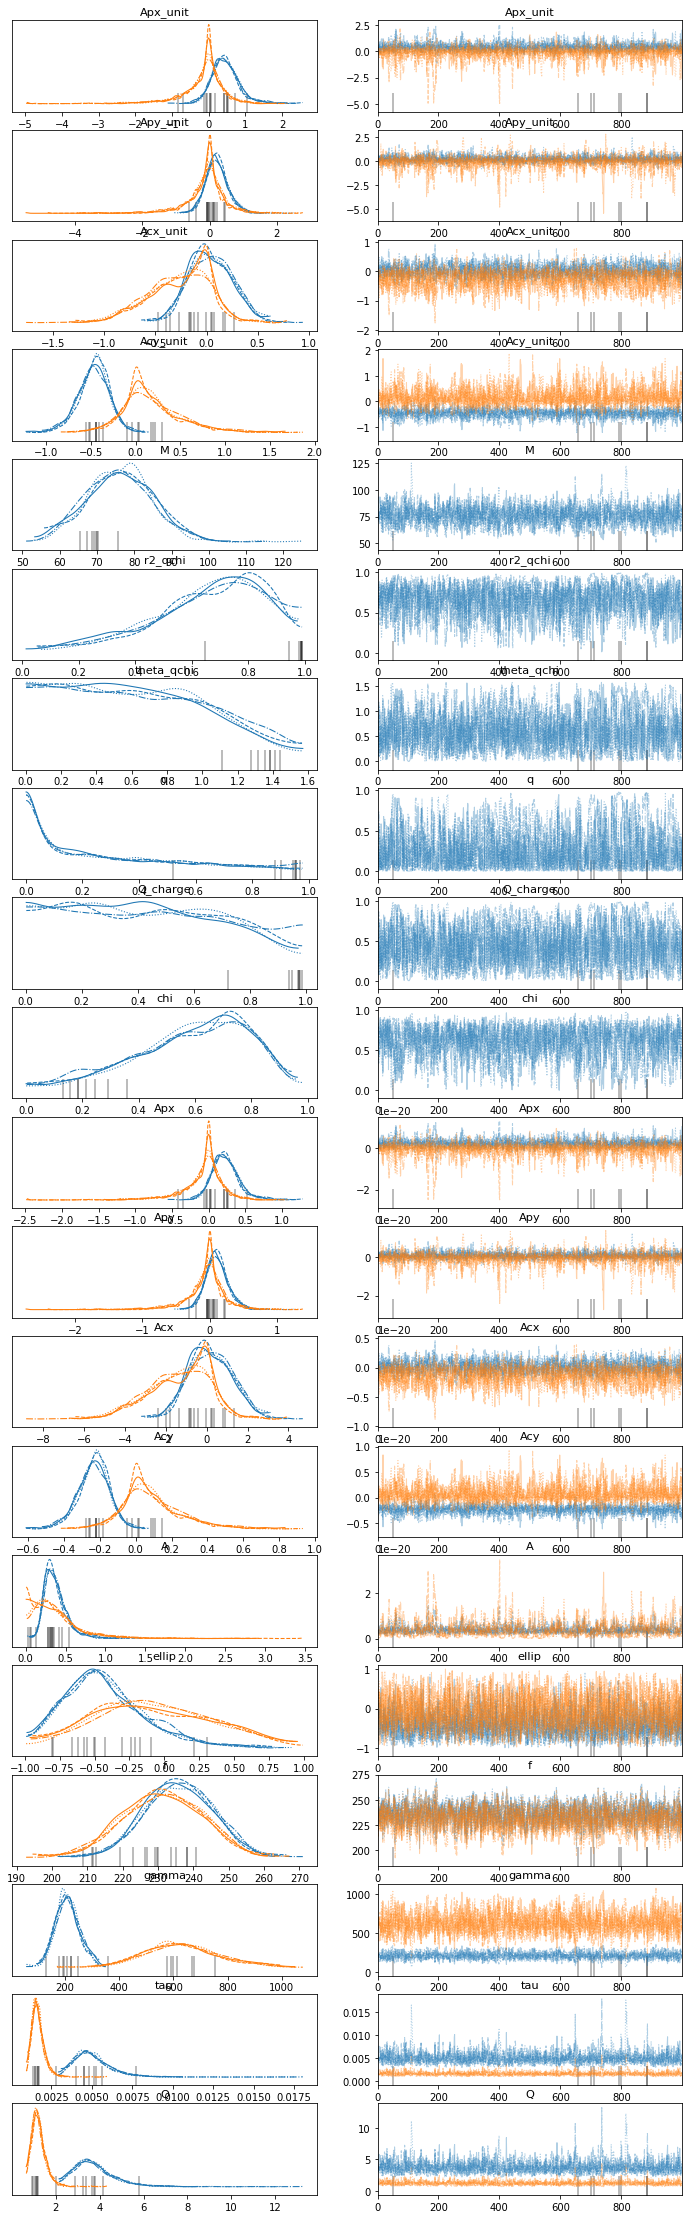

In [190]:
az.plot_trace(fit_charged_10perc.result)

<AxesSubplot:>

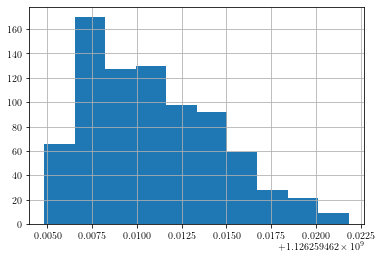

In [229]:
samps.geocent_peak.hist()

In [260]:
event = db.event("GW190521")

In [262]:
event.strain().keys()

--2022-07-19 16:43:59--  https://www.gw-openscience.org/eventapi/json/GWTC-2.1-confident/GW190521/v4/H-H1_GWOSC_16KHZ_R1-1242442952-32.hdf5
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4060254 (3.9M) [application/x-hdf]
Saving to: ‘./Data/StrainData/H-H1_GWOSC_16KHZ_R1-1242442952-32.hdf5’

     0K .......... .......... .......... .......... ..........  1%  591K 7s
    50K .......... .......... .......... .......... ..........  2% 1.17M 5s
   100K .......... .......... .......... .......... ..........  3%  126M 3s
   150K .......... .......... .......... .......... ..........  5% 25.8M 2s
   200K .......... .......... .......... .......... ..........  6% 1.21M 3s
   250K .......... .......... .......... .......... ..........  7% 1.20M 3s
   300K .......... .......... .......... .......... ..........  8%  146

HTTP request sent, awaiting response... 200 OK
Length: 4068406 (3.9M) [application/x-hdf]
Saving to: ‘./Data/StrainData/L-L1_GWOSC_16KHZ_R1-1242442952-32.hdf5’

     0K .......... .......... .......... .......... ..........  1%  573K 7s
    50K .......... .......... .......... .......... ..........  2% 1.19M 5s
   100K .......... .......... .......... .......... ..........  3% 1.17M 4s
   150K .......... .......... .......... .......... ..........  5% 1.21M 4s
   200K .......... .......... .......... .......... ..........  6%  211K 7s
   250K .......... .......... .......... .......... ..........  7%  877K 6s
   300K .......... .......... .......... .......... ..........  8% 1.21M 6s
   350K .......... .......... .......... .......... .......... 10% 1.20M 5s
   400K .......... .......... .......... .......... .......... 11%  783K 5s
   450K .......... .......... .......... .......... .......... 12%  195K 6s
   500K .......... .......... .......... .......... .......... 13% 1.01M 6s
   

--2022-07-19 16:44:05--  https://www.gw-openscience.org/eventapi/json/GWTC-2.1-confident/GW190521/v4/V-V1_GWOSC_16KHZ_R1-1242442952-32.hdf5
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2448756 (2.3M) [application/x-hdf]
Saving to: ‘./Data/StrainData/V-V1_GWOSC_16KHZ_R1-1242442952-32.hdf5’

     0K .......... .......... .......... .......... ..........  2%  236K 10s
    50K .......... .......... .......... .......... ..........  4%  276K 9s
   100K .......... .......... .......... .......... ..........  6%  360K 8s
   150K .......... .......... .......... .......... ..........  8%  623K 7s
   200K .......... .......... .......... .......... .......... 10%  354K 6s
   250K .......... .......... .......... .......... .......... 12%  601K 6s
   300K .......... .......... .......... .......... .......... 14%  55

dict_keys(['H1', 'L1', 'V1'])